In [1]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
import boto3
import json
import re
import keras
from keras.models import Sequential
from keras.layers import (Dense, LSTM, Dropout)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.model_selection import train_test_split

In [2]:
s3_client = boto3.client("s3")
s3_bucket_name = 'thesis-hydroponic-project'
s3_bucket_prefix = 'TemperatureAndHumidity2021/02/26/'

In [3]:
files = s3_client.list_objects(Bucket=s3_bucket_name, Prefix=s3_bucket_prefix)['Contents']
parsed_sensor_values = []
for file in files:
    if not os.path.isfile('.cache/' + file['Key']) or (datetime.now() - datetime.fromtimestamp(os.path.getctime('.cache/' + file['Key']))).days > 31:
        print("Fetching fresh file from S3:", file['Key'])
        s3_object = s3_client.get_object(Bucket=s3_bucket_name, Key= file['Key'])
        raw_sensor_values = s3_object['Body'].read().decode()
        clean_sensor_values = re.sub(",+", ",", raw_sensor_values)
        sensor_values = json.loads("[" + clean_sensor_values.strip(',') + "]")
    else:
        print("Load from cache:", file['Key'])
        with open('.cache/' + file['Key']) as f:
            sensor_values = json.load(f)
    parsed_sensor_values += sensor_values
    os.makedirs('.cache/' + os.path.dirname(file['Key']), exist_ok=True)
    with open('.cache/' + file['Key'], 'w') as f:
        json.dump(sensor_values, f)

Load from cache: TemperatureAndHumidity2021/02/26/07/ThesisHydroponicSensorDeliveryStream-1-2021-02-26-07-51-38-ec2c2568-eb19-4545-bb0e-0f16f95cb6e3
Load from cache: TemperatureAndHumidity2021/02/26/08/ThesisHydroponicSensorDeliveryStream-1-2021-02-26-08-06-42-1735bd58-32e4-4e15-9cb6-78d1ca2a6dcc
Load from cache: TemperatureAndHumidity2021/02/26/08/ThesisHydroponicSensorDeliveryStream-1-2021-02-26-08-21-43-be822a77-afd8-4342-868d-ddf0518a246e
Load from cache: TemperatureAndHumidity2021/02/26/08/ThesisHydroponicSensorDeliveryStream-1-2021-02-26-08-36-45-abfab403-9485-4dc2-af8f-b9a9c02be599
Load from cache: TemperatureAndHumidity2021/02/26/08/ThesisHydroponicSensorDeliveryStream-1-2021-02-26-08-51-45-5508bb3f-a726-43db-a425-0ee2e234e2b8
Load from cache: TemperatureAndHumidity2021/02/26/09/ThesisHydroponicSensorDeliveryStream-1-2021-02-26-09-06-51-82e4f6d1-6a67-4368-b05d-4002523400c7
Load from cache: TemperatureAndHumidity2021/02/26/09/ThesisHydroponicSensorDeliveryStream-1-2021-02-26-09-

In [4]:
data = pd.DataFrame(parsed_sensor_values)

In [5]:
data['temperature'] = data['temperature'].astype(float)
data['humidity'] = data['humidity'].astype(float)
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
data.sort_values('datetime', ascending=True, inplace=True)

In [7]:
data

,sensor_type,temperature,humidity,datetime
0,hydroponic sensor,14.0,38.0,2021-02-26 08:51:37
1,hydroponic sensor,15.0,36.0,2021-02-26 08:51:43
2,hydroponic sensor,15.0,36.0,2021-02-26 08:51:48
3,hydroponic sensor,15.0,36.0,2021-02-26 08:51:53
4,hydroponic sensor,15.0,35.0,2021-02-26 08:51:58
...,...,...,...,...
2141,hydroponic sensor,24.0,22.0,2021-02-27 00:59:26
2142,hydroponic sensor,24.0,22.0,2021-02-27 01:00:26
2143,hydroponic sensor,24.0,22.0,2021-02-27 01:01:26
2144,hydroponic sensor,24.0,22.0,2021-02-27 01:02:26


In [8]:
dataset = data.iloc[:, 1:2].values

In [9]:
# train_test_split(dataset, test_size=0.3, random_state = 0)
sc = MinMaxScaler(feature_range = (0,1))
dataset_scaled = sc.fit_transform(dataset)

In [10]:
prediction_interval_size = 60 # 60 minutes interval
sensor_index_to_predict = 0 # data.columns.values.tolist().index('temperature')
feature_values = []
label_values = []
for i in range(prediction_interval_size, dataset_scaled.shape[0]):
    feature_values.append(dataset_scaled[i-prediction_interval_size:i, sensor_index_to_predict])
    label_values.append(dataset_scaled[i, sensor_index_to_predict])
feature_values, label_values = np.array(feature_values), np.array(label_values)
feature_values = np.reshape(feature_values, (feature_values.shape[0], feature_values.shape[1], 1))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(feature_values, label_values, test_size=0.3, random_state=42)
train_size = 0.5
X_train = feature_values[:feature_values.shape[0] * train_size]
X_test = feature_values[feature_values.shape[0] * train_size:]
y_train = label_values[:feature_values.shape[0] * train_size]
y_test = label_values[feature_values.shape[0] * train_size:]

TypeError: slice indices must be integers or None or have an __index__ method

In [42]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
46/46 [==============================] - 4s 84ms/step - loss: 0.0674
Epoch 2/100
46/46 [==============================] - 4s 77ms/step - loss: 0.0153
Epoch 3/100
46/46 [==============================] - 4s 79ms/step - loss: 0.0132
Epoch 4/100
46/46 [==============================] - 4s 85ms/step - loss: 0.0124
Epoch 5/100
46/46 [==============================] - 4s 79ms/step - loss: 0.0127
Epoch 6/100
46/46 [==============================] - 4s 77ms/step - loss: 0.0105
Epoch 7/100
46/46 [==============================] - 4s 78ms/step - loss: 0.0097
Epoch 8/100
46/46 [==============================] - 4s 82ms/step - loss: 0.0094
Epoch 9/100
46/46 [==============================] - 4s 81ms/step - loss: 0.0087
Epoch 10/100
46/46 [==============================] - 4s 77ms/step - loss: 0.0098
Epoch 11/100
46/46 [==============================] - 4s 76ms/step - loss: 0.0079
Epoch 12/100
46/46 [==============================] - 4s 76ms/step - loss: 0.0079
Epoch 13/100
46/46 [=====

In [43]:
predicted_sensor_values = model.predict(X_test)#.reshape((predicted_sensor_values.shape[0],))
predicted_sensor_values = sc.inverse_transform(predicted_sensor_values)

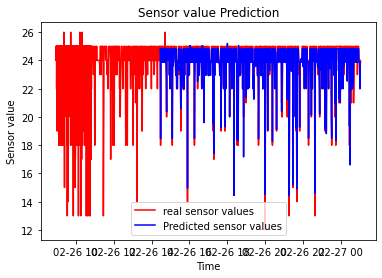

In [68]:
# Visualising the results

import matplotlib.pyplot as plt
p = sc.inverse_transform([y_test])
p2 = sc.inverse_transform([y_train])
plt.plot(data.loc[prediction_interval_size:, "datetime"], p2.reshape((p2.shape[1],)).tolist() +  p.reshape((p.shape[1],)).tolist(), color = "red", label = "real sensor values")
plt.plot(data.loc[prediction_interval_size + y_train.shape[0]:, "datetime"], predicted_sensor_values.reshape((predicted_sensor_values.shape[0],)).tolist(), color = "blue", label = "Predicted sensor values")
#plt.xticks(np.arange(0,459,50))
plt.title('Sensor value Prediction')
plt.xlabel('Time')
plt.ylabel('Sensor value')
plt.legend()
plt.show()

In [48]:
(sc.inverse_transform([y_test]) - predicted_sensor_values).mean()

0.09557589022115397

In [61]:
p.shape

(1, 626)

(626, 1)